In [ ]:
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from pandarallel import pandarallel, core

from exotools.spectra import read_stick_output
from exotools.exotools import states_df

from sklearn.linear_model import HuberRegressor
from sklearn.preprocessing import StandardScaler

from binslt.distributions import gaussian
from tqdm import tqdm 

from multiprocessing import cpu_count
import multiprocessing as mp
import subprocess as sp

In [21]:
df = read_stick_output("../XSEC/Stick/X2Pi_to_12Sigma-/OH_XS_300K.out",predicted_shifts=False)
df["Branch"] = df["J_upper"]-df["J_lower"]
df["Branch"] = np.select(
    [
        df["Branch"]>0,
        df["Branch"]==0,
        df["Branch"]<0
    ],
    [
        "R",
        "Q",
        "P"
    ])

In [ ]:
def fit_HuberRegressor(nu):
    nu_diff = np.diff(nu)
    nu      = nu[1:].reshape(-1,1)

    scaler = StandardScaler()
    nu_scaled = scaler.fit_transform(nu)

    model = HuberRegressor()
    model.fit(nu_scaled, nu_diff**2)

    mean_nu = scaler.mean_ [0]
    std_nu  = scaler.scale_[0]

    model.intercept_ = model.intercept_ - (model.coef_*mean_nu/std_nu)
    model.coef_ = model.coef_/std_nu

    return model

def predict_HuberRegressor(model, nu):
    if type(nu) == np.ndarray:
        pass
    elif type(nu) != np.ndarray:
        if type(nu) == list:
            nu = np.array([*nu])
        elif type(nu) == float or type(nu) == int:
            nu = np.array([nu])
    
    if len(nu) == 1:
        nu = nu.reshape(1,-1)
    elif len(nu) > 1:
        nu = nu.reshape(-1,1)

    return np.sqrt(model.predict(nu))

def get_line_profile(wavenumber_range,wavenumber, intensity, gamma=None, sigma=None, model = None):
    # sigma = gamma / (2 * np.sqrt(2 * np.log(2)))
    if gamma != None:
        sigma = gamma / (2 * np.sqrt(2 * np.log(2)))
    elif sigma != None:
        pass
    elif model != None:
        gamma = predict_HuberRegressor(model, wavenumber)
        sigma = gamma / (2 * np.sqrt(2 * np.log(2)))

    line_profile = gaussian(wavenumber_range, wavenumber, sigma)    
    
    line_profile *= intensity

    return line_profile

def get_widths(df, J_lower, Omega_lower):
    df_min = df[
        (df["J_lower"]==J_lower)&
        (df["Omega_lower"]==Omega_lower)
        ]
    
    grouped = df_min.groupby(["v_lower","v_upper"], as_index = False).agg(nu = ("nu","mean"))
    models = {}
    widths = pd.DataFrame(columns = [*df.columns]+["Sigma"])
    
    for v in grouped.v_lower.unique():
        curr = grouped[grouped.v_lower == v].sort_values("v_upper")
        nu = curr.nu.to_numpy()

        model = fit_HuberRegressor(nu)
        
        models[f"{v}"] = model
        curr = df[df["v_lower"]==v]

        curr["Sigma"] = predict_HuberRegressor(model, curr["nu"].to_numpy())/(2*np.sqrt(2*np.log(2)))
        
        widths = pd.concat([widths, curr])

    return widths

In [28]:
def split_dataframe(df, n):
    components = np.array_split(df, n)
    components = {f"{num}":comp for num, comp in enumerate(components)}
    return components

def chunk_yield(df, chunk_size = 1000):
    for start in range(0,len(df), chunk_size):
        yield df[start:start+chunk_size]

def get_xsec_iteration(df, wavenumber_range):
    nu = df["nu"].to_numpy()[:,np.newaxis]
    I  = df["I"].to_numpy()[:,np.newaxis]
    sigma = df["Sigma"].to_numpy()[:,np.newaxis]
    
    gaussians = gaussian(wavenumber_range, nu, sigma, I)

    return np.sum(gaussians, axis = 0)

def get_xsec_piece(df, wavenumber_range,chunk_size, write, fname):
    xsec_chunk = 0
    total = int(len(df)/chunk_size)

    for chunk in tqdm(chunk_yield(df, chunk_size),total=total):
        xsec_chunk += get_xsec_iteration(chunk, wavenumber_range)
    
    if write == True:
        np.savetxt(f"{fname}",xsec_chunk)
    elif write == False:
        return xsec_chunk

def get_xsec(df, wavenumber_range, chunk_size = 1000):
    df = get_widths(df, 1.5, -1.5)
    
    running = sp.Popen("mkdir fds_tmp_dir", shell = True)
    running.communicate()
    
    cores = cpu_count()
    components = split_dataframe(df, cores)

    processes = {}
    if __name__=="__main__":
        for i in range(0,cores):
            fname = f"./fds_tmp_dir/xsec_{i}"
            processes[f"{i}"] = mp.Process(
                target = get_xsec_piece,
                args = (components[f"{i}"], wavenumber_range, chunk_size, True, fname)
            )
        for proc in processes.values():
            proc.start()
        for proc in processes.values():
            proc.join()
    
    xsec = 0
    for i in range(0,cores):
        xsec += np.loadtxt(f"./fds_tmp_dir/xsec_{i}")

    running = sp.Popen("rm -r fds_tmp_dir", shell=True)
    running.communicate()
    return xsec
    
wavenumber_range = np.arange(0,133001,1)

xsec = get_xsec(df[df["I"]>1e-30], wavenumber_range, 100)

    

/tmp/ipykernel_30209/2511133813.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  curr["Sigma"] = predict_HuberRegressor(model, curr["nu"].to_numpy())/(2*np.sqrt(2*np.log(2)))
/tmp/ipykernel_30209/2511133813.py:72: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  widths = pd.concat([widths, curr])
/tmp/ipykernel_30209/2511133813.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

In [25]:
df[df["I"]>1e-30]

,nu,I,J_upper,E_upper,J_lower,E_lower,tau_upper,e/f_upper,Manifold_upper,v_upper,...,Sigma_upper,Omega_upper,tau_lower,e/f_lower,Manifold_lower,v_lower,Lambda_lower,Sigma_lower,Omega_lower,Branch
25,38830.2108,1.164774e-30,0.5,38956.4634,0.5,126.2526,-,f,12Sigma-,25,...,-0.5,-0.5,+,e,X2Pi,0,1.0,-0.5,0.5,Q
26,39068.4285,2.674235e-30,0.5,39194.6811,0.5,126.2526,-,f,12Sigma-,26,...,-0.5,-0.5,+,e,X2Pi,0,1.0,-0.5,0.5,Q
27,39313.7159,6.067488e-30,0.5,39439.9685,0.5,126.2526,-,f,12Sigma-,27,...,-0.5,-0.5,+,e,X2Pi,0,1.0,-0.5,0.5,Q
28,39566.0150,1.360701e-29,0.5,39692.2676,0.5,126.2526,-,f,12Sigma-,28,...,-0.5,-0.5,+,e,X2Pi,0,1.0,-0.5,0.5,Q
29,39825.2673,3.016719e-29,0.5,39951.5199,0.5,126.2526,-,f,12Sigma-,29,...,-0.5,-0.5,+,e,X2Pi,0,1.0,-0.5,0.5,Q
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298575,69949.2207,4.056030e-30,19.5,76725.6055,19.5,6776.3848,+,f,12Sigma-,103,...,0.5,0.5,-,e,X2Pi,0,-1.0,-0.5,-1.5,Q
298576,70638.5780,3.194166e-30,19.5,77414.9628,19.5,6776.3848,+,f,12Sigma-,104,...,0.5,0.5,-,e,X2Pi,0,-1.0,-0.5,-1.5,Q
298577,71333.8507,2.449544e-30,19.5,78110.2355,19.5,6776.3848,+,f,12Sigma-,105,...,0.5,0.5,-,e,X2Pi,0,-1.0,-0.5,-1.5,Q
298578,72035.0626,1.827740e-30,19.5,78811.4474,19.5,6776.3848,+,f,12Sigma-,106,...,0.5,0.5,-,e,X2Pi,0,-1.0,-0.5,-1.5,Q


(30000.0, 133000.0)

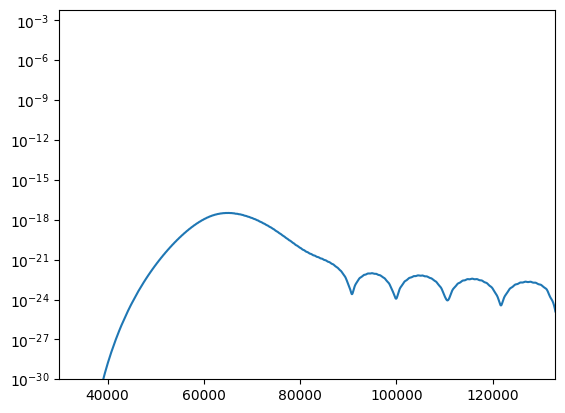

In [30]:
plt.plot(wavenumber_range, xsec)
plt.yscale("log")
plt.ylim(bottom = 1e-30)
plt.xlim(30000,133000)